# Learning pipeline

**Author**: Miguel Xochicale [@mxochicale](https://github.com/mxochicale)     
**Contributors**: Nhat Phung Tran Huy [@huynhatd13](https://github.com/huynhatd13); Hamideh Kerdegari [@hamidehkerdegari](https://github.com/hamidehkerdegari);  Alberto Gomez [@gomezalberto](https://github.com/)  


## History
* Feb2022: Adding initial models with small dataset   
* March2022: Improved datasets representation
* April2022: Adds dataloader for clips and videos
* May2022: Tidies VGG2D and VGG3D   
* June2022: Tidies basicVGG model and adds heuristics for hyperarameters 
* Week1, July2022: Integreate modules in source path
* Week2, July2022: Implements Tromp2022Net DOI: https://doi.org/10.1016/S2589-7500(21)00235-17
* Week3, July2022: Adds LeNet, AlexNet and VGGNets


## Summary
This notebook presents a learning pipeline to classify 4 chamber view from echocardiography datasets.

### How to run the notebook

1. Go to echocardiography repository path: `$HOME/repositories/echocardiography/`
2. Open echocardiography repo in pycharm and in the terminal type:
    ```
    git checkout master # or the branch
    git pull # to bring a local branch up-to-date with its remote version
    ```
3. Launch Notebook server  
    Go to you repository path: `cd $HOME/repositories/echocardiography/scripts/dataloaders` and type in the pycharm terminal:
    ```
    conda activate rt-ai-echo-VE 
    jupyter notebook
    ```
    which will open your web-browser.
    
    
### References
* "Proposed Regulatory Framework for Modifications to Artificial Intelligence/Machine Learning (AI/ML)-Based Software as a Medical Device (SaMD) - Discussion Paper and Request for Feedback". https://www.fda.gov/media/122535/download 
* https://nestedsoftware.com/2019/09/09/pytorch-image-recognition-with-convolutional-networks-4k17.159805.html 
* https://ai.stackexchange.com/questions/5769/in-a-cnn-does-each-new-filter-have-different-weights-for-each-input-channel-or
* Gomez A. et al. 2021 https://github.com/vital-ultrasound/lung/blob/main/multiclass_pytorch/datasets/LUSVideoDataset.py 
* Kerdegari H. et al. 2021 https://github.com/vital-ultrasound/lung/tree/main/multiclass_tensorflow
* https://learnopencv.com/pytorch-for-beginners-image-classification-using-pre-trained-models/
* https://github.com/shanglianlm0525/PyTorch-Networks



# Jupyter Notebook

## 1. Setting imports and datasets paths

In [1]:
import os
import sys
import argparse
import yaml
from pathlib import Path
import json
import time

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
#import matplotlib.animation as animation
from IPython.display import HTML #to be used with HTML(animation.ArtistAnimation().to_jshtml())
from tqdm import tqdm
import shutil

import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, precision_recall_fscore_support
from datetime import datetime


from typing import Dict, List, Tuple

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision

from torch.utils.data import DataLoader
import torch.utils.data as Data
from torchinfo import summary
from torchvision import transforms, utils, models

from source.dataloaders.EchocardiographicVideoDataset import EchoClassesDataset
from source.helpers.various import concatenating_YAML_via_tags, \
                                    plot_dataset_classes, \
                                    split_train_validate_sets
from source.helpers.learning_pipeline import get_class_distribution, \
                                            plot_from_dict, \
                                            creating_pair_of_clips, \
                                            pair_clips_labels, \
                                            animate_clips
from source.models.learning_misc import train_loop, \
                                        test_loop, \
                                        basicVGG #, VGG3D
                                        
                

HOME_PATH = os.path.expanduser(f'~')
USERNAME = os.path.split(HOME_PATH)[1]

REPOSITORY_PATH='repositories/echocardiography'
FULL_REPO_PATH = HOME_PATH+'/'+REPOSITORY_PATH
FULL_REPO_MODEL_PATH = HOME_PATH +'/' + REPOSITORY_PATH + '/data/models'
CONFIG_FILES_PATH= REPOSITORY_PATH + '/scripts/config_files/users_paths_files'
YML_FILE =  'config_users_paths_files_username_' + USERNAME + '.yml'
FULL_PATH_FOR_YML_FILE = os.path.join(HOME_PATH, CONFIG_FILES_PATH, YML_FILE)
PATH_for_temporal_files = os.path.join(HOME_PATH, 'datasets/vital-us/echocardiography/temporal-files')

## Setting TRAINING_CURVES_PATH
#CURRENT_PATH=os.path.abspath(os.getcwd())
RESULTS_PATH='scripts/learning-pipeline/results'
TRAINING_CURVES_PATH = os.path.join(FULL_REPO_PATH, RESULTS_PATH)

## Setting FULL_PATH_FOR_YML_FILE
yaml.add_constructor('!join', concatenating_YAML_via_tags)  ## register the tag handler
with open(FULL_PATH_FOR_YML_FILE, 'r') as yml:
    config = yaml.load(yml, Loader=yaml.FullLoader)

## Printing Versions and paths
print(f'PyTorch Version: {torch.__version__}')
print(f'Torchvision Version: {torchvision.__version__}')    
print(f'FULL_PATH_FOR_YML_FILE: {FULL_PATH_FOR_YML_FILE}' )
print(f'FULL_REPO_MODEL_PATH: {FULL_REPO_MODEL_PATH}' )
print(f'TRAINING_CURVES_PATH: {TRAINING_CURVES_PATH}' )


PyTorch Version: 1.9.0
Torchvision Version: 0.10.0a0
FULL_PATH_FOR_YML_FILE: /home/mx19/repositories/echocardiography/scripts/config_files/users_paths_files/config_users_paths_files_username_mx19.yml
FULL_REPO_MODEL_PATH: /home/mx19/repositories/echocardiography/data/models
TRAINING_CURVES_PATH: /home/mx19/repositories/echocardiography/scripts/learning-pipeline/results


## 2. Generate list text files for train and validate datasets

Edit config_users_paths_files_username_$USER.yml at '../config_files/users_paths_files/config_users_paths_files_username_template.yml' with the right paths and percentage of `ntraining`:  
```
#ECHODATASET_PATH = config['echodataset_path'] # Default
ECHODATASET_PATH = '/media/mx19/vitaluskcl/datasets/echocardiography/videos-echo-annotated-GOOD'
TRAINING_SPLITTING = 0.8 #config['ntraining'] #Default
randomise_file_list: False
```

In [2]:
##############################
##### Setting up device
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu") #or "cuda:NN" can also be used e.g., "cuda:0"
print(f'Device: {DEVICE}')


### Trump et al. 2022 
##"We trained the models on 55487 images from 1145 individual echocardiograms (appendix pp 2–3)." 
##Appendix pp 2–3.
##AC4: TRAINING: total videos 740 total frames 9615; T
##      TESTING: total videos:64 total frames 1218                


##############################
## Setting ECHODATASET_PATH; 
#ECHODATASET_PATH = config['echodataset_path'] # Default

ECHODATASET_PATH = '/media/mx19/vitaluskcl/datasets/echocardiography/videos-echo-annotated-05-subjects'
    #"BATCH_SIZE_OF_CLIPS": 20,
    #"FRAMES_PER_CLIP": 1,
    #"Train Dataset Size": 720,
    #"Test Dataset Size": 320,
    #"Validation Dataset Size": 280,

#ECHODATASET_PATH = '/media/mx19/vitaluskcl/datasets/echocardiography/videos-echo-annotated-10-subjects'
    #"BATCH_SIZE_OF_CLIPS": 20,
    #"FRAMES_PER_CLIP": 1,
    #"Train Dataset Size": 1280,
    #"Test Dataset Size": 560,
    #"Validation Dataset Size": 440,

#ECHODATASET_PATH = '/media/mx19/vitaluskcl/datasets/echocardiography/videos-echo-annotated-20-subjects'
    #"BATCH_SIZE_OF_CLIPS": 20,
    #"FRAMES_PER_CLIP": 1,
    #"Train Dataset Size": 2240,
    #"Test Dataset Size": 960,
    #"Validation Dataset Size": 720,

#ECHODATASET_PATH = '/media/mx19/vitaluskcl/datasets/echocardiography/videos-echo-annotated-31-subjects'
    #"BATCH_SIZE_OF_CLIPS": 20,
    #"FRAMES_PER_CLIP": 1,
    #"Train Dataset Size": 3620,
    #"Test Dataset Size": 1540,
    #"Validation Dataset Size": 880,



#ECHODATASET_PATH = '/media/mx19/vitaluskcl/datasets/echocardiography/videos-echo-annotated-in-verification40-49'



TRAINING_SPLITTING = 0.80 #config['ntraining'] #Default
FLAG_RANDOMISE_DATA=True #config['randomise_file_list'] #Default

split_train_validate_sets(  
                        ECHODATASET_PATH, #config['echodataset_path']
                        config['data_list_output_path'], 
                        TRAINING_SPLITTING,
                        FLAG_RANDOMISE_DATA
                        )

# PRETRANSFORM_IM_SIZE = [64, 64] #[650, 690] original pixel size for VenueGO
PRETRANSFORM_IM_SIZE = [128, 128] #[650, 690] original pixel size for VenueGO
# PRETRANSFORM_IM_SIZE = [256, 256] #[650, 690] original pixel size for VenueGO
# PRETRANSFORM_IM_SIZE = [512, 512] #[650, 690] original pixel size for VenueGO
# PRETRANSFORM_IM_SIZE = config['pretransform_im_size'] ##DEFAULT

### >> CHANGE DENSE LAYER FEATURES IN VGG3D
### >> `self.fc0 = nn.Linear(in_features=4194304, out_features=500) #128x128`

##############################
##### Experiments for Basic HYPERPARAMETER Heuristics 

#### TESTS
NUMBER_OF_FRAMES_PER_SEGMENT_IN_A_CLIP = 1; BATCH_SIZE_OF_CLIPS = 3; LEARNING_RATE= 0.00005; 


#################  LEARNING_RATE 
### EXPERIMENT 01,02,03,04
#NUMBER_OF_FRAMES_PER_SEGMENT_IN_A_CLIP = 1; BATCH_SIZE_OF_CLIPS = 20; LEARNING_RATE= 0.00005; 
#NUMBER_OF_FRAMES_PER_SEGMENT_IN_A_CLIP = 10; BATCH_SIZE_OF_CLIPS = 20; LEARNING_RATE= 0.000005; 
#NUMBER_OF_FRAMES_PER_SEGMENT_IN_A_CLIP = 10; BATCH_SIZE_OF_CLIPS = 20; LEARNING_RATE= 0.0000005; 
#NUMBER_OF_FRAMES_PER_SEGMENT_IN_A_CLIP = 10; BATCH_SIZE_OF_CLIPS = 20; LEARNING_RATE= 0.00000005; 

#################  BATCH_SIZE_OF_CLIPS with LEARNING_RATE= 0.000005 as it is the best peformance of prevous LRs 
### EXPERIMENT 04,06,07,08
#NUMBER_OF_FRAMES_PER_SEGMENT_IN_A_CLIP = 10; BATCH_SIZE_OF_CLIPS = 2; LEARNING_RATE= 0.000005; 
#NUMBER_OF_FRAMES_PER_SEGMENT_IN_A_CLIP = 10; BATCH_SIZE_OF_CLIPS = 5; LEARNING_RATE= 0.000005; 
#NUMBER_OF_FRAMES_PER_SEGMENT_IN_A_CLIP = 10; BATCH_SIZE_OF_CLIPS = 10; LEARNING_RATE= 0.000005; 
#NUMBER_OF_FRAMES_PER_SEGMENT_IN_A_CLIP = 10; BATCH_SIZE_OF_CLIPS = 15; LEARNING_RATE= 0.000005; 

#################  NUMBER_OF_FRAMES_PER_SEGMENT_IN_A_CLIP with LEARNING_RATE= 0.000005 and BATCH_SIZE_OF_CLIPS=10
### EXPERIMENT 09,10,11,12
#NUMBER_OF_FRAMES_PER_SEGMENT_IN_A_CLIP = 2; BATCH_SIZE_OF_CLIPS = 10; LEARNING_RATE= 0.000005; 
#NUMBER_OF_FRAMES_PER_SEGMENT_IN_A_CLIP = 7; BATCH_SIZE_OF_CLIPS = 10; LEARNING_RATE= 0.000005; 
#NUMBER_OF_FRAMES_PER_SEGMENT_IN_A_CLIP = 13; BATCH_SIZE_OF_CLIPS = 10; LEARNING_RATE= 0.000005; 
#NUMBER_OF_FRAMES_PER_SEGMENT_IN_A_CLIP = 20; BATCH_SIZE_OF_CLIPS = 10; LEARNING_RATE= 0.000005; 

##TOADD
### * NUMBER_OF_FRAMES_AND PARTICPANTS
### * OPTIMISERS 

# LEARNING_RATE =Trial and Error with diffent values  0.00005; 0.0005; 0.005 and 0.000001; 0.00001; 0.0001; 0.001  


MAX_EPOCHS = 500 #Alternatvely, make use of: config['max_epochs']


##############################
##### Setting up animation
interval_between_frames_in_milliseconds=33.3 ## 1/30=0.033333
frame_per_seconds_for_animated_frames=30


#SUBJECT_ID = '073'
#print(SUBJECT_ID)

### CUDA out of memory 
#NUMBER_OF_FRAMES_PER_SEGMENT_IN_A_CLIP = 10
#PRETRANSFORM_IM_SIZE = [128, 128] 
#RuntimeError: CUDA out of memory. Tried to allocate 7.81 GiB (GPU 0; 15.74 GiB total capacity; 8.51 GiB already allocated; 5.05 GiB free; 8.53 GiB reserved in total by PyTorch)
## REBOOT MACHINE
#RuntimeError: CUDA out of memory. Tried to allocate 7.81 GiB (GPU 0; 15.74 GiB total capacity; 8.51 GiB already allocated; 5.13 GiB free; 8.53 GiB reserved in total by PyTorch)



##############################
## Setting labels
label_id = ('BKGR', '4CV')




Device: cuda
======= video_filenames: ('/01NVb-003-042/T3/01NVb-003-042-3 echo.mp4', '/01NVb-003-040/T2/01NVb-003-040-2 echo.mp4', '/01NVb-003-042/T2/01NVb-003-042-2 echo.mp4', '/01NVb-003-044/T1/01NVb-003-044-2 echo.mp4', '/01NVb-003-042/T1/01NVb-003-042-1 echo.mp4', '/01NVb-003-044/T3/01NVb-003-044-3 echo.mp4', '/01NVb-003-043/T1/01NVb-003-043-2 echo.mp4', '/01NVb-003-045/T2/01NVB-003-045-2 echo.mp4', '/01NVb-003-045/T1/01NVb-003-045-1 echo.mp4', '/01NVb-003-041/T2/01NVb-003-041-2 echo.mp4', '/01NVb-003-041/T1/01NVb-003-041-1 echo.mp4', '/01NVb-003-043/T1/01NVb-003-043-1 echo.mp4', '/01NVb-003-041/T3/01NVb-003-041-3 echo.mp4', '/01NVb-003-043/T3/01NVb-003-043-3 echo.mp4', '/01NVb-003-045/T3/01NVb-003-045-3 echo.mp4', '/01NVb-003-040/T1/01NVb-003-040-1 echo.mp4')
======= label_filenames: ('/01NVb-003-042/T3/01nvb-003-042-3-4cv.json', '/01NVb-003-040/T2/01nvb-003-040-2-4cv.json', '/01NVb-003-042/T2/01nvb-003-042-2-4cv.json', '/01NVb-003-044/T1/01nvb-003-044-2-4cv.json', '/01NVb-003-042

## 2. Setting variables and loading datasets using pytorch dataloader

In [3]:
# Defining transforms that apply to the entire dataset.
# These transforms are not augmentation.
if config['use_pretransform_image_size']:
    pretransform = transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize(size=PRETRANSFORM_IM_SIZE),
        transforms.ToTensor(),
    ])
else:
    pretransform = None

    
    #config['use_train_augmentation']#Default
    
# These transforms have random parameters changing at each epoch.
if config['use_train_augmentation']:
    train_transform = transforms.Compose([
        transforms.ToPILImage(),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomRotation(degrees=5),  # in degrees
        transforms.RandomEqualize(p=0.5),
        #transforms.RandomRotation(degrees=2),  # in degrees
        #transforms.RandomEqualize(p=0.2),
        transforms.RandomAffine(degrees=0, translate=(0.1, 0.1), scale=(0.9, 1.1)),
        transforms.ToTensor(), 
    ])
else:
    transform = None
    
# These transforms have random parameters changing at each epoch.
if config['use_validation_augmentation']:
    val_transform = transforms.Compose([
    #transforms.ToPILImage(),
    #transforms.RandomHorizontalFlip(p=0.5),
    #transforms.RandomRotation(degrees=5),  # in degrees
    #transforms.RandomEqualize(p=0.5),
    #transforms.RandomAffine(degrees=0, translate=(0.1, 0.1), scale=(0.9, 1.1)),
    #transforms.ToTensor(), 
    ])
else:
    transform = None


train_dataset = EchoClassesDataset(
    echodataset_path=ECHODATASET_PATH,
    temporal_data_path=config['temporal_data_path'],
    participant_videos_list=config['participant_videos_list_train'],
    participant_path_json_list=config['participant_path_json_list_train'],
    crop_bounds_for_us_image=config['crop_bounds_for_us_image'],
    pretransform_im_size=PRETRANSFORM_IM_SIZE,
    pretransform=pretransform,
    number_of_frames_per_segment_in_a_clip=NUMBER_OF_FRAMES_PER_SEGMENT_IN_A_CLIP, #config['number_of_frames_per_segment_in_a_clip'],
    sliding_window_length_in_percentage_of_frames_per_segment=config['sliding_window_length_in_percentage_of_frames_per_segment'],
    device=DEVICE,
    max_background_duration_in_secs=config['max_background_duration_in_secs'],
    #transform=None,#transform=train_transform,
    transform=train_transform,
    use_tmp_storage=config['use_tmp_storage']
    )

validation_dataset = EchoClassesDataset(
    echodataset_path=ECHODATASET_PATH,
    temporal_data_path=config['temporal_data_path'],
    participant_videos_list=config['participant_videos_list_validation'],
    participant_path_json_list=config['participant_path_json_list_validation'],
    crop_bounds_for_us_image=config['crop_bounds_for_us_image'],
    pretransform_im_size=PRETRANSFORM_IM_SIZE,
    pretransform=pretransform,
    number_of_frames_per_segment_in_a_clip=NUMBER_OF_FRAMES_PER_SEGMENT_IN_A_CLIP, #config['number_of_frames_per_segment_in_a_clip'],
    sliding_window_length_in_percentage_of_frames_per_segment=config['sliding_window_length_in_percentage_of_frames_per_segment'],
    device=DEVICE,
    max_background_duration_in_secs=config['max_background_duration_in_secs'],
    transform=None,#transform=train_transform,
    use_tmp_storage=config['use_tmp_storage']
    )


## Spliting train_dataset into train_set and test_set
Ntdt = train_dataset.__len__()
ntraining = 0.7

Ntrain=round(Ntdt*ntraining)
Ntest = round(Ntdt - (Ntdt*ntraining))
print(f'Ntrain size: {Ntrain}, Ntest size: {Ntest}, "Ntrain+Ntest" size={Ntrain+Ntest}')
train_set, test_set = torch.utils.data.random_split(train_dataset, [Ntrain, Ntest])


Ntrain size: 32, Ntest size: 14, "Ntrain+Ntest" size=46


## 3. Plotting Class Distribution (creates temp clips and it takes few minutes)

[INFO] [EchoClassesDataset.__getitem__()] - computing clips and saving to temporary folder /home/mx19/datasets/vital-us/echocardiography/temporal-files/echovideodatafiles_FRAMESPERCLIP1_PIXELSIZE_128W128H
class_distribution(train_set): {'BKGR': 15, '4CV': 17}
class_distribution(validation_dataset): {'BKGR': 10, '4CV': 10}
class_distribution(test_set): {'BKGR': 8, '4CV': 6}
Number of frames for training datasets 32
Number of frames for Validation datasets 20
Number of frames for testing datasets 14


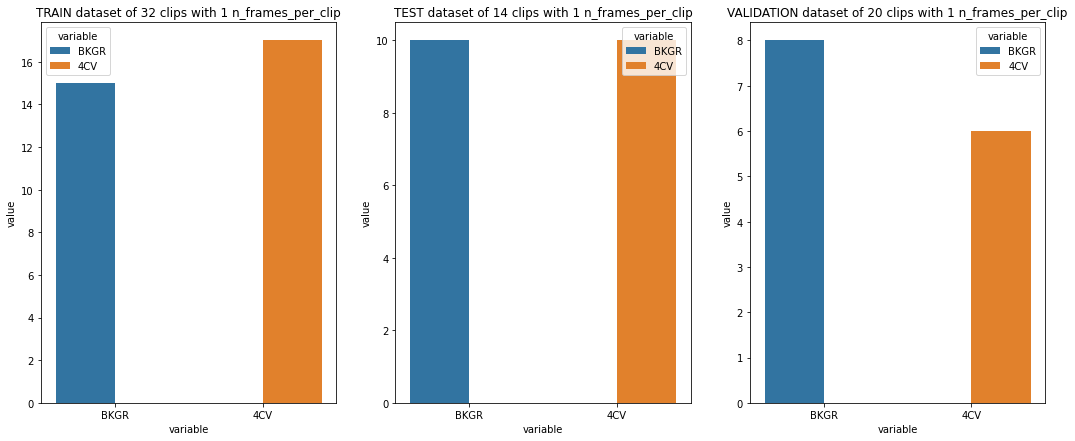

In [4]:
train_set_class_dict = get_class_distribution(train_set,label_id)
val_set_class_dict = get_class_distribution(validation_dataset,label_id)
test_set_class_dict = get_class_distribution(test_set,label_id)

print(f'class_distribution(train_set): {train_set_class_dict}')
print(f'class_distribution(validation_dataset): {val_set_class_dict}' )
print(f'class_distribution(test_set): {test_set_class_dict}')
    
#number_of_frames_per_segment_in_a_clip = config['number_of_frames_per_segment_in_a_clip']    
print(f'Number of frames for training datasets {len(train_set)*NUMBER_OF_FRAMES_PER_SEGMENT_IN_A_CLIP}')
print(f'Number of frames for Validation datasets {len(validation_dataset)*NUMBER_OF_FRAMES_PER_SEGMENT_IN_A_CLIP}')
print(f'Number of frames for testing datasets {len(test_set)*NUMBER_OF_FRAMES_PER_SEGMENT_IN_A_CLIP}')

plot_title_train_label= f'TRAIN dataset of {len(train_set)} clips with {NUMBER_OF_FRAMES_PER_SEGMENT_IN_A_CLIP} n_frames_per_clip'
plot_title_val_label= f'VALIDATION dataset of {len(validation_dataset)} clips with {NUMBER_OF_FRAMES_PER_SEGMENT_IN_A_CLIP} n_frames_per_clip'
plot_title_test_label= f'TEST dataset of {len(test_set)} clips with {NUMBER_OF_FRAMES_PER_SEGMENT_IN_A_CLIP} n_frames_per_clip'

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(18,7))
plot_from_dict(train_set_class_dict, plot_title=plot_title_train_label, ax=axes[0])
plot_from_dict(val_set_class_dict, plot_title=plot_title_test_label, ax=axes[1])
plot_from_dict(test_set_class_dict, plot_title=plot_title_val_label, ax=axes[2])
plt.show()



## 4. Animating frames of one clip of the dataloader

In [5]:
print(f'---------------------------------------')
clips=creating_pair_of_clips(train_dataset, label_id)
pair_clips_and_labels = pair_clips_labels(clips)


---------------------------------------
 CLIP:00 of BKGR label for torch.Size([1, 1, 128, 128]) TOTAL_FRAMES: 151 from clip_frame_clip_idx 137
 CLIP:01 of BKGR label for torch.Size([1, 1, 128, 128]) TOTAL_FRAMES: 150 from clip_frame_clip_idx 66
 CLIP:02 of BKGR label for torch.Size([1, 1, 128, 128]) TOTAL_FRAMES: 40 from clip_frame_clip_idx 14
 CLIP:03 of BKGR label for torch.Size([1, 1, 128, 128]) TOTAL_FRAMES: 151 from clip_frame_clip_idx 77
 CLIP:04 of BKGR label for torch.Size([1, 1, 128, 128]) TOTAL_FRAMES: 150 from clip_frame_clip_idx 79
 CLIP:05 of BKGR label for torch.Size([1, 1, 128, 128]) TOTAL_FRAMES: 151 from clip_frame_clip_idx 19
 CLIP:06 of BKGR label for torch.Size([1, 1, 128, 128]) TOTAL_FRAMES: 150 from clip_frame_clip_idx 142
 CLIP:07 of BKGR label for torch.Size([1, 1, 128, 128]) TOTAL_FRAMES: 151 from clip_frame_clip_idx 43
 CLIP:08 of BKGR label for torch.Size([1, 1, 128, 128]) TOTAL_FRAMES: 151 from clip_frame_clip_idx 86
 CLIP:09 of BKGR label for torch.Size([1,

<Figure size 432x288 with 0 Axes>

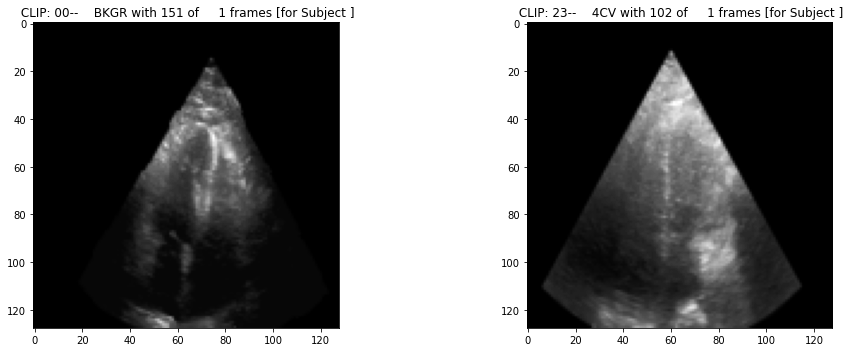

In [6]:
#average_HR =
#fps = 30
# 60 # beats per minute
#Beats-per-minute: 60 BPM
#Beats-per-second: 1 Hz
#Cycle-per-second: 1 (Cycle/s)

PAIR_OF_CLIPS = pair_clips_and_labels[0]

animated_frames=animate_clips(PAIR_OF_CLIPS, label_id, NUMBER_OF_FRAMES_PER_SEGMENT_IN_A_CLIP,
                  interval_between_frames_in_milliseconds)
HTML(animated_frames.to_jshtml())      


# ##SAVE ANIMATIONS
# for idx in range(0,len(pair_clips_labels)):
#     PAIR_OF_CLIPS = pair_clips_labels[idx]
#     print( f' pair_clips_labels {str(PAIR_OF_CLIPS[2])} {str(PAIR_OF_CLIPS[6])}')
    

## 5. Displayting frames in the dataloader

In [7]:

print(f'====================================================')
print(f'train_dataset.__len__() = {train_set.__len__()}')
train_dataloader = torch.utils.data.DataLoader(
    train_set, 
    batch_size=BATCH_SIZE_OF_CLIPS, 
    shuffle=True,
    num_workers=0)


print(f'====================================================')
print(f'len(train_dataloader): {len(train_dataloader)} BATCHES of BATCH_SIZE_OF_CLIPS {BATCH_SIZE_OF_CLIPS}')
for clip_batch_idx, sample_batched in enumerate(train_dataloader):
    print(f'  ====================================================')
    sample_batched_images=sample_batched[0]
    sample_batched_labels=sample_batched[1]
    print(f'    BATCH_OF_CLIPS_INDEX : {clip_batch_idx} / {len(train_dataloader) - 1}')
    print(f'    sample_batched_labels.size(): {  sample_batched_labels.size()  }')
    print(f'    sample_batched_labels.squeeze().size(): {  sample_batched_labels.squeeze().size()  }')
    print(f'    sample_batched_images.size(): {sample_batched_images.size()}')

    for BATCH_SIZE_IDX, label in enumerate(sample_batched_labels):
        print(f'        BATCH_SIZE_IDX {BATCH_SIZE_IDX} ')
        print(f'          label: {label}')
        sample_batched_idx_image = sample_batched_images[BATCH_SIZE_IDX,...]
        print(f'          Sample_batched_idx_image.size()  {sample_batched_idx_image.size() }'  )

        grid = utils.make_grid(sample_batched_idx_image)
        print(f'          Grid size {grid.size()}' )
#         plt.figure(figsize =(20,20) )
#         plt.imshow( grid.cpu().detach().numpy().transpose(1, 2, 0) )
#         plt.title(f'BATCH_SIZE_IDX {BATCH_SIZE_IDX}; Label: {label_id[label]}')
#         plt.axis('off')
#         plt.ioff()
#         plt.show()


print(f'====================================================')
print(f' test_dataset.__len__() = {test_set.__len__()}')
test_dataloader = torch.utils.data.DataLoader(
    test_set, 
    batch_size=BATCH_SIZE_OF_CLIPS, 
    shuffle=True, 
    num_workers=0)

print(f'====================================================')
print(f' validation_dataset.__len__() = {validation_dataset.__len__()}')
val_dataloader = torch.utils.data.DataLoader(
    validation_dataset, 
    batch_size=BATCH_SIZE_OF_CLIPS, 
    shuffle=True, 
    num_workers=0)

train_dataset.__len__() = 32
len(train_dataloader): 11 BATCHES of BATCH_SIZE_OF_CLIPS 3
    BATCH_OF_CLIPS_INDEX : 0 / 10
    sample_batched_labels.size(): torch.Size([3])
    sample_batched_labels.squeeze().size(): torch.Size([3])
    sample_batched_images.size(): torch.Size([3, 1, 1, 128, 128])
        BATCH_SIZE_IDX 0 
          label: 1
          Sample_batched_idx_image.size()  torch.Size([1, 1, 128, 128])
          Grid size torch.Size([3, 128, 128])
        BATCH_SIZE_IDX 1 
          label: 1
          Sample_batched_idx_image.size()  torch.Size([1, 1, 128, 128])
          Grid size torch.Size([3, 128, 128])
        BATCH_SIZE_IDX 2 
          label: 1
          Sample_batched_idx_image.size()  torch.Size([1, 1, 128, 128])
          Grid size torch.Size([3, 128, 128])
    BATCH_OF_CLIPS_INDEX : 1 / 10
    sample_batched_labels.size(): torch.Size([3])
    sample_batched_labels.squeeze().size(): torch.Size([3])
    sample_batched_images.size(): torch.Size([3, 1, 1, 128, 128])
   

## 7. Define networks
See `$HOMErepositories/echocardiography/source/models/learning_misc.py` to amend or implement other models

In [8]:
# ######################################
# ##### Define TrompNet2022 architecture
# class TrompNet2022(nn.Module):

#     def __init__(self, input_pixel_size, n_batch_size_of_clips, n_frames_per_clip, n_classes=2):
#         """
#         Simple Video classifier by Tromp et al. 2022. DOI https://doi.org/10.1016/S2589-7500(21)00235-1
        
        
#         The first classifier was a supervised CNN, composed of 
#             * four convolutional layers, 
#             * a dense layer, and 
#             * a softmax output layer. 
#         This model was trained with a categorical cross-entropy loss function.
        
#         Args:
#             input_pixel_size:  shape of the input image. Should be a 2 element vector for a 2D video (width, height) [e.g. 128, 128].
#             n_batch_size_of_clips: (self explanatory)
#             n_frames_per_clip: (self explanatory)
#             n_classes: number of output classes
#         """
        
        
#         super(TrompNet2022, self).__init__()
#         self.name = 'tromp2022Net'
        
#         self.input_pixel_size = input_pixel_size #[128, 128]
#         self.n_batch_size_of_clips = n_batch_size_of_clips  #BATCH_SIZE_OF_CLIPS
#         self.n_frames_per_clip = n_frames_per_clip #NUMBER_OF_FRAMES_PER_SEGMENT_IN_A_CLIP
#         self.n_classes = n_classes
#         #print(f'self.n_frames_per_clip {self.n_frames_per_clip}')
#         self.n_features = np.prod(self.input_pixel_size) * self.n_frames_per_clip
        

#         #self.n_batch_size_of_clips    
#         self.conv0 = nn.Conv2d(in_channels=1, 
#                                out_channels=64,
#                                kernel_size=(3, 3), 
#                                stride=(1, 1), #H_{in}/strideA, W_{in}/strideB
#                                padding = (0, 0), 
#                                #dilation=(0, 0)
#                               )
#         #Input: (N,Cin,Hin,Win)(N, C_{in}, H_{in}, W_{in})
#         #Output: (N,Cout,Hout,Wout)(N, C_{out}, H_{out}, W_{out})
#         #N is a batch size

#         self.conv1 = nn.Conv2d(in_channels=64, 
#                        out_channels=128,
#                        kernel_size=(3, 3), 
#                        stride=(1, 1), #H_{in}/strideA, W_{in}/strideB
#                        padding = (0, 0), 
#                        #dilation=(0, 0)
#                       )

        
#         self.conv2 = nn.Conv2d(in_channels=128, 
#                        out_channels=32,
#                        kernel_size=(3, 3), 
#                        stride=(1, 1), #H_{in}/strideA, W_{in}/strideB
#                        padding = (0, 0), 
#                        #dilation=(0, 0)
#                       )        
        
#         self.conv3 = nn.Conv2d(in_channels=32, 
#                        out_channels=10,
#                        kernel_size=(3, 3), 
#                        stride=(1, 1), #H_{in}/strideA, W_{in}/strideB
#                        padding = (0, 0), 
#                        #dilation=(0, 0)
#                       )
                
        
#         self.flatten = nn.Flatten()
#         #self.relu = nn.ReLU()
#         #self.sigmoid = nn.Sigmoid()

#         self.fc0 = nn.Linear(in_features=144000, out_features=self.n_classes)

#         ### Softmax
#         #self.softmax = nn.Softmax() # UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
#         #self.softmax = nn.Softmax(dim=0) #along row
#         self.softmax = nn.Softmax(dim=1) #along the column (for linear output)
#         #https://discuss.pytorch.org/t/implicit-dimension-choice-for-softmax-warning/12314/12
        

        
#     def forward(self, x: torch.Tensor) -> torch.Tensor:
#         # print(f'x.shape(): {x.size()}') ##[batch_size, channels, depth, height, width]
#         # x = x.permute(0,2,1,3,4)##[batch_size, depth, channels, height, width]
#         #print(f'x.shape(): {x.size()}') # torch.Size([20, 1, 1, 128, 128]) 
#         x = torch.squeeze(x,dim=1)
#         #x = torch.unsqueeze(x,dim=1)
#         #print(f'x.shape(): {x.size()}') # torch.Size([20, 1, 128, 128])
        
#         #print(f'X.shape(): {x.size()}')
#         x = self.conv0(x)
#         x = self.conv1(x)
#         x = self.conv2(x)
#         x = self.conv3(x)
#         #print(f'conv3(x): {x.size()}')
        

#         x = self.flatten(x)
#         #print(f'self.flatten(x) size() {x.size()}')  # x.shape(): torch.Size([4, 983040])
#         x = self.fc0(x)
#         #print(f'fc0(): {x.size()}')
        
#         x = self.softmax(x)
#         #print(f'x.shape(): {x.size()}')

#         return x

# ######################################
# ##### LeNet5 https://medium.datadriveninvestor.com/cnn-architectures-from-scratch-c04d66ac20c2
# class LeNet5(nn.Module):
#     def __init__(self, n_classes=2):
        
#         super(LeNet5, self).__init__()
#         self.name = 'LeNet5'
        
#         self.tanh = nn.Tanh()      
#         self.pool = nn.AvgPool2d(kernel_size=(2,2),stride=(2,2))
#         self.conv1 = nn.Conv2d(in_channels=1,out_channels=6,kernel_size=(5,5),stride=(1,1))
#         self.conv2 = nn.Conv2d(in_channels=6,out_channels=16,kernel_size=(5,5),stride=(1,1))
#         self.conv3 = nn.Conv2d(in_channels=16,out_channels=120,kernel_size=(5,5),stride=(1,1))
#         self.flatten = nn.Flatten()
#         self.linear1 = nn.Linear(75000, 84)
#         self.linear2 = nn.Linear(84, n_classes)

#     def forward(self,x):
#         x = torch.squeeze(x,dim=1)
#         x = self.tanh(self.conv1(x))
#         x = self.pool(x)
#         x = self.tanh(self.conv2(x))
#         x = self.pool(x)
#         x = self.tanh(self.conv3(x))
#         #print(f'x.shape(): {x.size()}') 
#         #x = x.reshape(x.shape[0],-1) #75000
#         x = self.flatten(x)
# #         print(f'x.shape(): {x.size()}') 
#         x = self.tanh(self.linear1(x))
#         x = self.linear2(x)
#         return x    




# ######################################
# ##### LeNet5 https://blog.paperspace.com/writing-lenet5-from-scratch-in-python/
# class LeNet5(nn.Module):
#     def __init__(self, n_classes=2):
        
#         super(LeNet5, self).__init__()
#         self.name = 'LeNet5'
        
#         self.layer1 = nn.Sequential(
#             nn.Conv2d(1, 6, kernel_size=5, stride=1, padding=0),
#             nn.BatchNorm2d(6),
#             nn.ReLU(),
#             nn.MaxPool2d(kernel_size = 2, stride = 2))
#         self.layer2 = nn.Sequential(
#             nn.Conv2d(6, 16, kernel_size=5, stride=1, padding=0),
#             nn.BatchNorm2d(16),
#             nn.ReLU(),
#             nn.MaxPool2d(kernel_size = 2, stride = 2))
#         self.fc = nn.Linear(13456, 120)
#         self.relu = nn.ReLU()
#         self.fc1 = nn.Linear(120, 84)
#         self.relu1 = nn.ReLU()
#         self.fc2 = nn.Linear(84, n_classes)
    
#     def forward(self,x):
#         x = torch.squeeze(x,dim=1)
#         x = self.layer1(x)
#         x = self.layer2(x)
#         x = x.reshape(x.size(0), -1)
#         x = self.fc(x)
#         x = self.relu(x)
#         x = self.fc1(x)
#         x = self.relu1(x)
#         x = self.fc2(x)
        
#         return x    



# #https://github.com/lychengr3x/LeNet-5-Implementation-Using-Pytorch/blob/master/LeNet-5%20Implementation%20Using%20Pytorch.ipynb
# class LeNet5(nn.Module):

#     # network structure
#     def __init__(self, n_classes=2):
        
#         super(LeNet5, self).__init__()
#         self.conv1 = nn.Conv2d(1, 6, 5, padding=2)
#         self.conv2 = nn.Conv2d(6, 16, 5)
#         #self.fc1   = nn.Linear(16*5*5, 120)
#         self.fc1   = nn.Linear(14400, 120)
#         self.fc2   = nn.Linear(120, 84)
#         self.fc3   = nn.Linear(84, n_classes)
#         self.flatten = nn.Flatten()
        
#     def forward(self, x):
#         '''
#         One forward pass through the network.
        
#         Args:
#             x: input
#         '''
#         x = torch.squeeze(x,dim=1)
#         x = F.max_pool2d(F.relu(self.conv1(x)), (2, 2))
#         x = F.max_pool2d(F.relu(self.conv2(x)), (2, 2))
#         #x = x.view(-1, self.num_flat_features(x))
#         #x = x.reshape(x.size(0), -1)
#         x = self.flatten(x)
#         #print(f'x.shape(): {x.size()}') 
#         x = F.relu(self.fc1(x))
#         x = F.relu(self.fc2(x))
#         x = self.fc3(x)
#         return x

#     def num_flat_features(self, x):
#         '''
#         Get the number of features in a batch of tensors `x`.
#         '''
#         size = x.size()[1:]
#         return np.prod(size)



# class AlexNet(nn.Module):
#     def __init__(self, n_classes=2):
#         super(AlexNet, self).__init__()
#         self.features = nn.Sequential(
#             nn.Conv2d(1, 64, kernel_size=11, stride=4, padding=2),
#             nn.ReLU(),
#             nn.LocalResponseNorm(size=5,alpha=0.0001,beta=0.75,k=2),
#             nn.MaxPool2d(kernel_size=3, stride=2),
#             nn.Conv2d(64, 192, kernel_size=5, padding=2),
#             nn.ReLU(),
#             nn.MaxPool2d(kernel_size=3, stride=2),
#             nn.Conv2d(192, 384, kernel_size=3, padding=1),
#             nn.ReLU(),
#             nn.Conv2d(384, 256, kernel_size=3, padding=1),
#             nn.ReLU(),
#             nn.Conv2d(256, 256, kernel_size=3, padding=1),
#             nn.ReLU(),
#             nn.MaxPool2d(kernel_size=3, stride=2),
#         )
#         self.avgpool = nn.AdaptiveAvgPool2d((6, 6))
#         self.classifier = nn.Sequential(
#             nn.Dropout(),
#             nn.Linear(256 * 6 * 6, 4096),
#             nn.ReLU(),
#             nn.Dropout(),
#             nn.Linear(4096, 4096),
#             nn.ReLU(),
#             nn.Linear(4096, n_classes),
#         )
        
#     def forward(self, x):
#         x = torch.squeeze(x,dim=1)
#         x = self.features(x)
#         x = self.avgpool(x)
#         x = torch.flatten(x, 1)
#         x = self.classifier(x)
#         return x


# #https://github.com/pytorch/vision/blob/main/torchvision/models/alexnet.py    
# class AlexNet(nn.Module):
#     def __init__(self, n_classes=2):
#         super(AlexNet, self).__init__()
#         self.features = nn.Sequential(
#             nn.Conv2d(1, 64, kernel_size=11, stride=4, padding=2),
#             nn.ReLU(inplace=True),
# #             nn.LocalResponseNorm(size=5,alpha=0.0001,beta=0.75,k=2),
#             nn.MaxPool2d(kernel_size=3, stride=2),
#             nn.Conv2d(64, 192, kernel_size=5, padding=2),
#             nn.ReLU(inplace=True),
#             nn.MaxPool2d(kernel_size=3, stride=2),
#             nn.Conv2d(192, 384, kernel_size=3, padding=1),
#             nn.ReLU(inplace=True),
#             nn.Conv2d(384, 256, kernel_size=3, padding=1),
#             nn.ReLU(inplace=True),
#             nn.Conv2d(256, 256, kernel_size=3, padding=1),
#             nn.ReLU(inplace=True),
#             nn.MaxPool2d(kernel_size=3, stride=2),
#         )
#         self.avgpool = nn.AdaptiveAvgPool2d((6, 6))
#         self.classifier = nn.Sequential(
#             nn.Dropout(p=0.5),
#             nn.Linear(256 * 6 * 6, 4096),
#             #nn.Linear(9216, 4096),
#             nn.ReLU(inplace=True),
#             nn.Dropout(p=0.5),
#             nn.Linear(4096, 4096),
#             nn.ReLU(inplace=True),
#             nn.Linear(4096, n_classes),
#         )
        
#     def forward(self, x):
#         x = torch.squeeze(x,dim=1)
#         #print(f'x.shape(): {x.size()}') 
#         x = self.features(x)
#         x = self.avgpool(x)
#         x = torch.flatten(x, 1)
#         #print(f'x.shape(): {x.size()}') 
#         x = self.classifier(x)
#         return x
    
    
#https://blog.paperspace.com/alexnet-pytorch/    
class AlexNet(nn.Module):
    def __init__(self, n_classes=2):
        super(AlexNet, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(1, 96, kernel_size=11, stride=4, padding=0),
            nn.BatchNorm2d(96),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 3, stride = 2))
        self.layer2 = nn.Sequential(
            nn.Conv2d(96, 256, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 3, stride = 2))
        self.layer3 = nn.Sequential(
            nn.Conv2d(256, 384, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(384),
            nn.ReLU())
        self.layer4 = nn.Sequential(
            nn.Conv2d(384, 384, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(384),
            nn.ReLU())
        self.layer5 = nn.Sequential(
            nn.Conv2d(384, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 3, stride = 2))
        self.fc = nn.Sequential(
            nn.Dropout(0.5),
            #nn.Linear(9216, 4096),            
            nn.Linear(1024, 4096),
            nn.ReLU())
        self.fc1 = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(4096, 4096),
            nn.ReLU())
        self.fc2= nn.Sequential(
            nn.Linear(4096, n_classes))
        
    def forward(self, x):
        x = torch.squeeze(x,dim=1)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.layer5(x)
        x = x.reshape(x.size(0), -1)
        #print(f'x.shape(): {x.size()}')
        #x = torch.flatten(x, 1)
        x = self.fc(x)
        x = self.fc1(x)
        x = self.fc2(x)
        return x 


# #https://developpaper.com/example-of-pytorch-implementing-alexnet/
# class AlexNet(nn.Module):
#   def __init__(self,n_classes=2):
#     super(AlexNet,self).__init__()
#     self.feature_extraction = nn.Sequential(
#       nn.Conv2d(in_channels=1,out_channels=96,kernel_size=11,stride=4,padding=2,bias=False),
#       nn.ReLU(inplace=True),
#       nn.MaxPool2d(kernel_size=3,stride=2,padding=0),
#       nn.Conv2d(in_channels=96,out_channels=192,kernel_size=5,stride=1,padding=2,bias=False),
#       nn.ReLU(inplace=True),
#       nn.MaxPool2d(kernel_size=3,stride=2,padding=0),
#       nn.Conv2d(in_channels=192,out_channels=384,kernel_size=3,stride=1,padding=1,bias=False),
#       nn.ReLU(inplace=True),
#       nn.Conv2d(in_channels=384,out_channels=256,kernel_size=3,stride=1,padding=1,bias=False),
#       nn.ReLU(inplace=True),
#       nn.Conv2d(in_channels=256,out_channels=256,kernel_size=3,stride=1,padding=1,bias=False),
#       nn.ReLU(inplace=True),
#       nn.MaxPool2d(kernel_size=3, stride=2, padding=0),
#     )
#     self.classifier = nn.Sequential(
#       nn.Dropout(p=0.5),
#       #nn.Linear(in_features=256*6*6,out_features=4096),
#       nn.Linear(in_features=2304,out_features=4096),
#       nn.ReLU(inplace=True),
#       nn.Dropout(p=0.5),
#       nn.Linear(in_features=4096, out_features=4096),
#       nn.ReLU(inplace=True),
#       nn.Linear(in_features=4096, out_features=n_classes),
#     )
#   def forward(self,x):
#     x = torch.squeeze(x,dim=1)
#     x = self.feature_extraction(x)
#     #print(f'x.shape(): {x.size()}')
#     #x = x.view(x.size(0),256*6*6)
#     x = torch.flatten(x, 1)
#     #print(f'x.shape(): {x.size()}')
#     x = self.classifier(x)
#     return x





## 8. Sanity checks for the model and dataloaders

In [9]:
##################################################################
##################################################################
##################################################################

##################################################################
##################################################################
##################################################################
##### Tensor Shape
#tensor_shape_size = [BATCH_SIZE_OF_CLIPS, config['number_of_frames_per_segment_in_a_clip'], 1, 128, 128]
#model = basicVGGNet(tensor_shape_size)

#n_frames_per_clip 
#model = VGG3D(PRETRANSFORM_IM_SIZE, NUMBER_OF_FRAMES_PER_SEGMENT_IN_A_CLIP) #print(config['pretransform_im_size']) #(128, 128)
#model = basicVGG(PRETRANSFORM_IM_SIZE, NUMBER_OF_FRAMES_PER_SEGMENT_IN_A_CLIP) #torch.Size([BATCH_SIZE_OF_CLIPS, CLASS_NUMBER])
#model = TrompNet2022(PRETRANSFORM_IM_SIZE, BATCH_SIZE_OF_CLIPS, NUMBER_OF_FRAMES_PER_SEGMENT_IN_A_CLIP) #print(config['pretransform_im_size']) #(128, 128)
# model = LeNet5()
model = AlexNet()

model.to(DEVICE) # Place model on GPU

print(model) 
#print(str(summary(model, (1, 32, 32), depth=1)))

### Sanity check
#print(len(train_dataloader)) #6 BATCHES of 10=BATCH_SIZE_OF_CLIPS
sample_batched = next(iter(train_dataloader))
#print(sample_batched[0].shape) #torch.Size([10, 60, 1, 128, 128])
#print(sample_batched[1])#tensor([1, 1, 0, 0, 1, 1, 0, 1, 1, 1])
#print(sample_batched[2]) #tensor([47, 42,  0, 51, 49, 75, 67, 67, 62, 84])
#print(sample_batched[3]) #tensor([105, 102,  43, 106,  94, 161, 151, 183, 150, 151])

clip_batch = sample_batched[0]
#print(f'clip_batch.size() {clip_batch.size()}') ##torch.Size([4, 60, 1, 128, 128])
#                                                ##[batch_size, channels, depth, height, width]

# # frames = image.to(device)
print(model(clip_batch).shape) #torch.Size([4, 2])
print(  type(model(clip_batch))  )  #torch.Size([4, 2]) #<class 'torch.Tensor'>

# #https://stackoverflow.com/questions/59129812/how-to-avoid-cuda-out-of-memory-in-pytorch
del sample_batched
torch.cuda.empty_cache()

AlexNet(
  (layer1): Sequential(
    (0): Conv2d(1, 96, kernel_size=(11, 11), stride=(4, 4))
    (1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(96, 256, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer3): Sequential(
    (0): Conv2d(256, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(384, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (layer4): Sequential(
    (0): Conv2d(384, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(384, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  

/home/mx19/anaconda3/envs/rt-ai-echo-VE/lib/python3.8/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /tmp/pip-req-build-pma2oi4d/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


torch.Size([3, 2])
<class 'torch.Tensor'>


## 8. Define Optimizer
1. Set learning rate for how much the model is updated per batch.
2. Set total epoch number, as we have shuffle and random transforms, so the training data of every epoch is different.
3. Set the number of clips per batch

In [10]:
#model = VGG3D(PRETRANSFORM_IM_SIZE, NUMBER_OF_FRAMES_PER_SEGMENT_IN_A_CLIP) #print(config['pretransform_im_size']) #(128, 128)
#model = basicVGG(PRETRANSFORM_IM_SIZE, NUMBER_OF_FRAMES_PER_SEGMENT_IN_A_CLIP) #torch.Size([BATCH_SIZE_OF_CLIPS, CLASS_NUMBER])
#model = TrompNet2022(PRETRANSFORM_IM_SIZE, BATCH_SIZE_OF_CLIPS, NUMBER_OF_FRAMES_PER_SEGMENT_IN_A_CLIP) #print(config['pretransform_im_size']) #(128, 128)

# model = LeNet5()
# gamma=.001 #LetNet_5()
# rho=.9 #LetNet_5()

model = AlexNet()
#gamma=0.005#AlexNet
gamma=0.001#AlexNet
pshi=0.005#AlexNet
rho=0.9#AlexNet

model.to(DEVICE) # Place model on GPU
criterion = nn.CrossEntropyLoss()
#optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
#optimizer = torch.optim.SGD(model.parameters(), lr=gamma, momentum=rho) #LeNet5
optimizer = torch.optim.SGD(model.parameters(), lr=gamma, weight_decay = pshi, momentum = rho)  #AlexNet

## PRINT MODEL
print(f'====================================================')
print(model)

# ### PRINT model.named_parameters
# print(f'====================================================')
# for name, param in model.named_parameters():
#     if param.requires_grad:
#         print(name, param.data)



AlexNet(
  (layer1): Sequential(
    (0): Conv2d(1, 96, kernel_size=(11, 11), stride=(4, 4))
    (1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(96, 256, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer3): Sequential(
    (0): Conv2d(256, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(384, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (layer4): Sequential(
    (0): Conv2d(384, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(384, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  

## 9. Training loop

In [11]:
### TRAINING
#clip_batch_size = tuple(train_dataloader.dataset.__getitem__(0)[0].shape) ##(60, 1, 128, 128) frames, chs, [width, height]
#print(clip_batch_size)


startt = time.time()
print(f'Starting training loop {startt}')


############################
####### BINARY ACCURACY MODULE
def binary_accuracy(y_pred, y_test):
    """
    binary_accuracy to calculate accuracy per epoch.
    """
    y_pred_tag = torch.log_softmax(y_pred, dim = 1)
    _, y_pred_tags = torch.max(y_pred_tag, dim = 1)
    correct_results_sum = (y_pred_tags == y_test).sum().float()
    accuracy = correct_results_sum/y_test.shape[0]
    accuracy = torch.round(accuracy * 100)
    return accuracy


############################
####### TRAIN LOOP MODULE
def train_loop(train_dataloader, model, criterion, optimizer, device):
    """
    train_loop
    Arguments:
        dataloader, model, criterion, optimizer, device

    Return:
        train_epoch_loss
    """
    train_epoch_loss = 0
    train_acc_loss_epoch = 0
    step_train = 0
    #size = len(train_dataloader.dataset)
    for clip_batch_idx, sample_batched in enumerate(train_dataloader):
        step_train += 1
        X_train_batch, y_train_batch = sample_batched[0].to(device), sample_batched[1].to(device)

        #print(f' BATCH_OF_CLIPS_INDEX: {clip_batch_idx} ')
        # print(f'----------------------------------------------------------')
        # print(f'   X_train_batch.size(): {X_train_batch.size()}') # torch.Size([9, 60, 1, 128, 128]) clips, frames, channels, [width, height]
        # print(f'   y_train_batch.size(): {y_train_batch.size()}') # torch.Size([9])

        # Compute prediction and loss
        y_train_pred = model(X_train_batch) #torch.Size([9, 2])
        #y_train_pred = model(X_train_batch).squeeze()  # torch.Size([9, 2])
        
        train_loss = criterion(y_train_pred, y_train_batch)
        train_acc = binary_accuracy(y_train_pred, y_train_batch)

        # Backpropagation
        optimizer.zero_grad()
        train_loss.backward()
        optimizer.step()

        # if clip_batch_idx % 10 == 0: ## Print loss values every 10 clip batches
        #     train_loss, current = train_loss.item(), clip_batch_idx * len(X_train_batch)
        #     print(f"loss: {train_loss:>7f}  [{current:>5d}/{size:>5d}]")

        train_epoch_loss += train_loss.detach().item()
        train_acc_loss_epoch += train_acc.detach().item()

    train_epoch_loss /= step_train
    train_acc_loss_epoch /= step_train

    return train_epoch_loss, train_acc_loss_epoch


############################
####### TEST LOOP MODULE
def test_loop(dataloader, model, criterion, device):
    """
    Test loop 
    
    Arguments:
        dataloader, model, criterion, optimizer, device

    Return:
        test_epoch_loss, correct
    """

    train_epoch_acc = 0
    step_test = 0
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_epoch_loss, correct = 0, 0

    with torch.no_grad():
        #model.eval()
        #val_epoch_loss = 0
        #val_epoch_acc = 0
        for clip_batch_idx, sample_val_batched in enumerate(dataloader):
            step_test += 1
            X_val_batch, y_val_batch = sample_val_batched[0].to(device), sample_val_batched[1].to(device)
            X_val_batch, y_val_batch = X_val_batch.to(device), y_val_batch.to(device)

            y_val_pred = model(X_val_batch)
            test_epoch_loss += criterion(y_val_pred, y_val_batch).detach().item()
            correct += (y_val_pred.argmax(1) == y_val_batch).type(torch.float).sum().detach().item()

    test_epoch_loss /= num_batches
    correct /= size

    return test_epoch_loss, correct


#Dictionaries to store the accuracy/epoch and loss/epoch for both train and validation sets.
loss_stats = {
    'train': [],
    'test': [],
    #"val": []
}
accuracy_stats = {
    'train': [],
    'test': [],
    #"val": []
}

#for epoch in tqdm(range(1, MAX_EPOCHS)):   
for epoch in range(MAX_EPOCHS):
    print("-" * 10)
    print(f"EPOCH {epoch + 1}/{MAX_EPOCHS}")
    model.train()
    epoch_loss = 0
    step = 0
    
    
    train_epoch_loss, train_acc_loss_epoch = train_loop(train_dataloader, model, criterion, optimizer, DEVICE)
    
    
    model.eval()
    test_epoch_loss, correct = test_loop(val_dataloader, model, criterion, DEVICE)

    #print(f'Epoch {epoch+0:02}: | Average Train Loss: {train_epoch_loss:.3f} | Average Train Acc: {train_epoch_acc:.5f} | Average Validation Loss: {val_epoch_loss:.3f} | Average Validation Acc: {val_epoch_acc:.5f} ')
    #print(f'Epoch {epoch+0:02}: | Average Train Loss: {train_epoch_loss:.3f} |Average Train Acc: {train_epoch_acc:.5f}  ')
    
    #print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_epoch_loss:>8f} \n")

    print(f'Epoch {epoch+0:02}: | Average Train Loss: {train_epoch_loss:.3f} Average Train Accuracy Loss: {(train_acc_loss_epoch):>0.1f}% ')
    
    print(f"Test Error: \n Test Accuracy: {(100*correct):>0.1f}%, Avg Test loss: {test_epoch_loss:>8f} \n")
    
    
    loss_stats['train'].append(train_epoch_loss)
    loss_stats['test'].append(test_epoch_loss)
    accuracy_stats['train'].append(train_acc_loss_epoch)
    accuracy_stats['test'].append(100*correct)
            
print("DONE TRAINING LOOP!")



endt = time.time()
elapsed_time = endt - startt
print(f'Finishing training loop {endt}')
print(f'Elapsed time for the training loop: {elapsed_time} (s)')

#model_path = ' /home/mx19/repositories/echocardiography/models' 
print(f' {FULL_REPO_MODEL_PATH}')
torch.save(model.state_dict(), os.path.join(FULL_REPO_MODEL_PATH, "metric_model.pth"))
print("Saved metric model")

print(loss_stats)
print(accuracy_stats)


Starting training loop 1658095037.8662493
----------
EPOCH 1/500
Epoch 00: | Average Train Loss: 0.827 Average Train Accuracy Loss: 46.9% 
Test Error: 
 Test Accuracy: 50.0%, Avg Test loss: 0.692009 

----------
EPOCH 2/500
Epoch 01: | Average Train Loss: 1.315 Average Train Accuracy Loss: 37.9% 
Test Error: 
 Test Accuracy: 50.0%, Avg Test loss: 0.785164 

----------
EPOCH 3/500
Epoch 02: | Average Train Loss: 1.034 Average Train Accuracy Loss: 40.9% 
Test Error: 
 Test Accuracy: 50.0%, Avg Test loss: 0.683558 

----------
EPOCH 4/500
Epoch 03: | Average Train Loss: 0.722 Average Train Accuracy Loss: 66.7% 
Test Error: 
 Test Accuracy: 50.0%, Avg Test loss: 0.690141 

----------
EPOCH 5/500
Epoch 04: | Average Train Loss: 1.109 Average Train Accuracy Loss: 50.1% 
Test Error: 
 Test Accuracy: 50.0%, Avg Test loss: 0.691942 

----------
EPOCH 6/500
Epoch 05: | Average Train Loss: 0.904 Average Train Accuracy Loss: 48.5% 
Test Error: 
 Test Accuracy: 50.0%, Avg Test loss: 0.683907 

----

Epoch 52: | Average Train Loss: 0.654 Average Train Accuracy Loss: 54.5% 
Test Error: 
 Test Accuracy: 50.0%, Avg Test loss: 0.704865 

----------
EPOCH 54/500
Epoch 53: | Average Train Loss: 0.750 Average Train Accuracy Loss: 47.0% 
Test Error: 
 Test Accuracy: 50.0%, Avg Test loss: 0.713249 

----------
EPOCH 55/500
Epoch 54: | Average Train Loss: 0.713 Average Train Accuracy Loss: 48.5% 
Test Error: 
 Test Accuracy: 50.0%, Avg Test loss: 0.699292 

----------
EPOCH 56/500
Epoch 55: | Average Train Loss: 0.691 Average Train Accuracy Loss: 46.9% 
Test Error: 
 Test Accuracy: 50.0%, Avg Test loss: 0.692026 

----------
EPOCH 57/500
Epoch 56: | Average Train Loss: 0.713 Average Train Accuracy Loss: 53.1% 
Test Error: 
 Test Accuracy: 45.0%, Avg Test loss: 0.691767 

----------
EPOCH 58/500
Epoch 57: | Average Train Loss: 0.728 Average Train Accuracy Loss: 45.5% 
Test Error: 
 Test Accuracy: 50.0%, Avg Test loss: 0.710133 

----------
EPOCH 59/500
Epoch 58: | Average Train Loss: 0.747 Av

Epoch 104: | Average Train Loss: 0.669 Average Train Accuracy Loss: 59.1% 
Test Error: 
 Test Accuracy: 50.0%, Avg Test loss: 0.697244 

----------
EPOCH 106/500
Epoch 105: | Average Train Loss: 0.710 Average Train Accuracy Loss: 45.5% 
Test Error: 
 Test Accuracy: 60.0%, Avg Test loss: 0.698480 

----------
EPOCH 107/500
Epoch 106: | Average Train Loss: 0.683 Average Train Accuracy Loss: 54.5% 
Test Error: 
 Test Accuracy: 55.0%, Avg Test loss: 0.693039 

----------
EPOCH 108/500
Epoch 107: | Average Train Loss: 0.718 Average Train Accuracy Loss: 57.7% 
Test Error: 
 Test Accuracy: 50.0%, Avg Test loss: 0.691634 

----------
EPOCH 109/500
Epoch 108: | Average Train Loss: 0.684 Average Train Accuracy Loss: 66.8% 
Test Error: 
 Test Accuracy: 50.0%, Avg Test loss: 0.687318 

----------
EPOCH 110/500
Epoch 109: | Average Train Loss: 0.712 Average Train Accuracy Loss: 48.5% 
Test Error: 
 Test Accuracy: 50.0%, Avg Test loss: 0.705119 

----------
EPOCH 111/500
Epoch 110: | Average Train L

Epoch 156: | Average Train Loss: 0.622 Average Train Accuracy Loss: 69.7% 
Test Error: 
 Test Accuracy: 50.0%, Avg Test loss: 0.701774 

----------
EPOCH 158/500
Epoch 157: | Average Train Loss: 0.629 Average Train Accuracy Loss: 72.8% 
Test Error: 
 Test Accuracy: 60.0%, Avg Test loss: 0.720200 

----------
EPOCH 159/500
Epoch 158: | Average Train Loss: 0.627 Average Train Accuracy Loss: 59.2% 
Test Error: 
 Test Accuracy: 60.0%, Avg Test loss: 0.663532 

----------
EPOCH 160/500
Epoch 159: | Average Train Loss: 0.739 Average Train Accuracy Loss: 48.6% 
Test Error: 
 Test Accuracy: 60.0%, Avg Test loss: 0.757250 

----------
EPOCH 161/500
Epoch 160: | Average Train Loss: 0.680 Average Train Accuracy Loss: 54.5% 
Test Error: 
 Test Accuracy: 60.0%, Avg Test loss: 0.681546 

----------
EPOCH 162/500
Epoch 161: | Average Train Loss: 0.706 Average Train Accuracy Loss: 56.1% 
Test Error: 
 Test Accuracy: 55.0%, Avg Test loss: 0.645817 

----------
EPOCH 163/500
Epoch 162: | Average Train L

Epoch 208: | Average Train Loss: 0.573 Average Train Accuracy Loss: 69.6% 
Test Error: 
 Test Accuracy: 75.0%, Avg Test loss: 0.525088 

----------
EPOCH 210/500
Epoch 209: | Average Train Loss: 0.576 Average Train Accuracy Loss: 66.8% 
Test Error: 
 Test Accuracy: 75.0%, Avg Test loss: 0.474996 

----------
EPOCH 211/500
Epoch 210: | Average Train Loss: 0.524 Average Train Accuracy Loss: 78.7% 
Test Error: 
 Test Accuracy: 75.0%, Avg Test loss: 0.500551 

----------
EPOCH 212/500
Epoch 211: | Average Train Loss: 0.672 Average Train Accuracy Loss: 62.2% 
Test Error: 
 Test Accuracy: 80.0%, Avg Test loss: 0.458153 

----------
EPOCH 213/500
Epoch 212: | Average Train Loss: 0.620 Average Train Accuracy Loss: 57.5% 
Test Error: 
 Test Accuracy: 70.0%, Avg Test loss: 0.581142 

----------
EPOCH 214/500
Epoch 213: | Average Train Loss: 0.770 Average Train Accuracy Loss: 56.2% 
Test Error: 
 Test Accuracy: 60.0%, Avg Test loss: 0.545241 

----------
EPOCH 215/500
Epoch 214: | Average Train L

Epoch 260: | Average Train Loss: 0.650 Average Train Accuracy Loss: 63.6% 
Test Error: 
 Test Accuracy: 65.0%, Avg Test loss: 0.502194 

----------
EPOCH 262/500
Epoch 261: | Average Train Loss: 0.559 Average Train Accuracy Loss: 68.3% 
Test Error: 
 Test Accuracy: 75.0%, Avg Test loss: 0.474589 

----------
EPOCH 263/500
Epoch 262: | Average Train Loss: 0.632 Average Train Accuracy Loss: 62.1% 
Test Error: 
 Test Accuracy: 80.0%, Avg Test loss: 0.449778 

----------
EPOCH 264/500
Epoch 263: | Average Train Loss: 0.530 Average Train Accuracy Loss: 66.7% 
Test Error: 
 Test Accuracy: 80.0%, Avg Test loss: 0.492277 

----------
EPOCH 265/500
Epoch 264: | Average Train Loss: 0.474 Average Train Accuracy Loss: 80.5% 
Test Error: 
 Test Accuracy: 80.0%, Avg Test loss: 0.459434 

----------
EPOCH 266/500
Epoch 265: | Average Train Loss: 0.518 Average Train Accuracy Loss: 74.4% 
Test Error: 
 Test Accuracy: 75.0%, Avg Test loss: 0.431704 

----------
EPOCH 267/500
Epoch 266: | Average Train L

Epoch 312: | Average Train Loss: 0.474 Average Train Accuracy Loss: 75.8% 
Test Error: 
 Test Accuracy: 75.0%, Avg Test loss: 0.485339 

----------
EPOCH 314/500
Epoch 313: | Average Train Loss: 0.549 Average Train Accuracy Loss: 80.5% 
Test Error: 
 Test Accuracy: 85.0%, Avg Test loss: 0.456371 

----------
EPOCH 315/500
Epoch 314: | Average Train Loss: 0.492 Average Train Accuracy Loss: 72.8% 
Test Error: 
 Test Accuracy: 75.0%, Avg Test loss: 0.487493 

----------
EPOCH 316/500
Epoch 315: | Average Train Loss: 0.456 Average Train Accuracy Loss: 78.8% 
Test Error: 
 Test Accuracy: 75.0%, Avg Test loss: 0.420863 

----------
EPOCH 317/500
Epoch 316: | Average Train Loss: 0.571 Average Train Accuracy Loss: 69.8% 
Test Error: 
 Test Accuracy: 75.0%, Avg Test loss: 0.467224 

----------
EPOCH 318/500
Epoch 317: | Average Train Loss: 0.500 Average Train Accuracy Loss: 74.4% 
Test Error: 
 Test Accuracy: 75.0%, Avg Test loss: 0.448716 

----------
EPOCH 319/500
Epoch 318: | Average Train L

Epoch 364: | Average Train Loss: 0.518 Average Train Accuracy Loss: 71.3% 
Test Error: 
 Test Accuracy: 80.0%, Avg Test loss: 0.405971 

----------
EPOCH 366/500
Epoch 365: | Average Train Loss: 0.486 Average Train Accuracy Loss: 78.9% 
Test Error: 
 Test Accuracy: 80.0%, Avg Test loss: 0.419703 

----------
EPOCH 367/500
Epoch 366: | Average Train Loss: 0.476 Average Train Accuracy Loss: 77.4% 
Test Error: 
 Test Accuracy: 75.0%, Avg Test loss: 0.479477 

----------
EPOCH 368/500
Epoch 367: | Average Train Loss: 0.474 Average Train Accuracy Loss: 81.9% 
Test Error: 
 Test Accuracy: 80.0%, Avg Test loss: 0.421692 

----------
EPOCH 369/500
Epoch 368: | Average Train Loss: 0.450 Average Train Accuracy Loss: 74.5% 
Test Error: 
 Test Accuracy: 70.0%, Avg Test loss: 0.442401 

----------
EPOCH 370/500
Epoch 369: | Average Train Loss: 0.408 Average Train Accuracy Loss: 81.9% 
Test Error: 
 Test Accuracy: 80.0%, Avg Test loss: 0.381185 

----------
EPOCH 371/500
Epoch 370: | Average Train L

Epoch 416: | Average Train Loss: 0.492 Average Train Accuracy Loss: 80.5% 
Test Error: 
 Test Accuracy: 75.0%, Avg Test loss: 0.419809 

----------
EPOCH 418/500
Epoch 417: | Average Train Loss: 0.476 Average Train Accuracy Loss: 74.4% 
Test Error: 
 Test Accuracy: 80.0%, Avg Test loss: 0.493785 

----------
EPOCH 419/500
Epoch 418: | Average Train Loss: 0.469 Average Train Accuracy Loss: 74.3% 
Test Error: 
 Test Accuracy: 95.0%, Avg Test loss: 0.303866 

----------
EPOCH 420/500
Epoch 419: | Average Train Loss: 0.505 Average Train Accuracy Loss: 72.9% 
Test Error: 
 Test Accuracy: 80.0%, Avg Test loss: 0.447725 

----------
EPOCH 421/500
Epoch 420: | Average Train Loss: 0.486 Average Train Accuracy Loss: 72.7% 
Test Error: 
 Test Accuracy: 85.0%, Avg Test loss: 0.402095 

----------
EPOCH 422/500
Epoch 421: | Average Train Loss: 0.513 Average Train Accuracy Loss: 69.7% 
Test Error: 
 Test Accuracy: 75.0%, Avg Test loss: 0.464078 

----------
EPOCH 423/500
Epoch 422: | Average Train L

Epoch 468: | Average Train Loss: 0.572 Average Train Accuracy Loss: 62.2% 
Test Error: 
 Test Accuracy: 75.0%, Avg Test loss: 0.424513 

----------
EPOCH 470/500
Epoch 469: | Average Train Loss: 0.437 Average Train Accuracy Loss: 74.2% 
Test Error: 
 Test Accuracy: 90.0%, Avg Test loss: 0.340213 

----------
EPOCH 471/500
Epoch 470: | Average Train Loss: 0.527 Average Train Accuracy Loss: 75.7% 
Test Error: 
 Test Accuracy: 65.0%, Avg Test loss: 0.461682 

----------
EPOCH 472/500
Epoch 471: | Average Train Loss: 0.492 Average Train Accuracy Loss: 80.4% 
Test Error: 
 Test Accuracy: 80.0%, Avg Test loss: 0.470739 

----------
EPOCH 473/500
Epoch 472: | Average Train Loss: 0.385 Average Train Accuracy Loss: 80.4% 
Test Error: 
 Test Accuracy: 65.0%, Avg Test loss: 0.470848 

----------
EPOCH 474/500
Epoch 473: | Average Train Loss: 0.435 Average Train Accuracy Loss: 78.9% 
Test Error: 
 Test Accuracy: 65.0%, Avg Test loss: 0.709261 

----------
EPOCH 475/500
Epoch 474: | Average Train L

## 10. Visualize accuracy and loss performance and storage

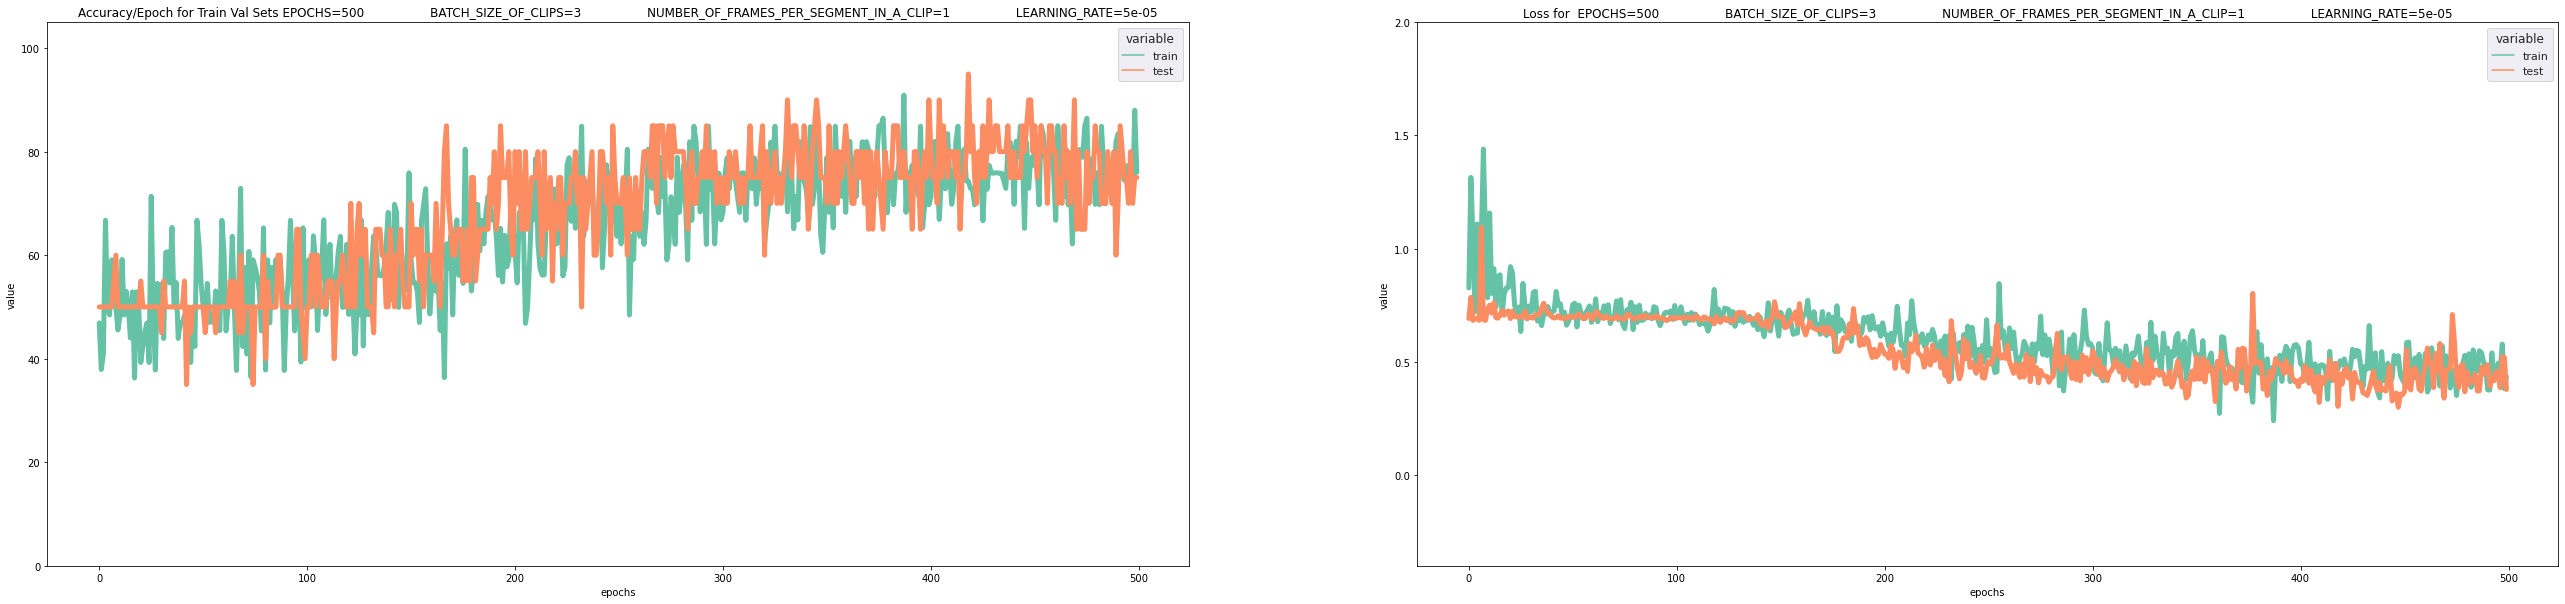

In [12]:
## Convert stats as dataframes
loss_df = pd.DataFrame.from_dict(loss_stats).reset_index().melt(id_vars=['index']).rename(columns={"index":"epochs"})
acc_df = pd.DataFrame.from_dict(accuracy_stats).reset_index().melt(id_vars=['index']).rename(columns={"index":"epochs"})
## Concatenate dataframes and dictionaries
loss_df.insert(0, 'curve', 'Loss', True)
acc_df.insert(0, 'curve', 'Acc', True)
valuesall = [loss_df, acc_df]
values_all = pd.concat(valuesall)

all_stats = {
    'ACC': accuracy_stats,
    'LOS': loss_stats,
}


## Saving training curves at $HOME/repositories/echocardiography/scripts/learning-pipeline/results
os.chdir(TRAINING_CURVES_PATH)


#################################
#### PLOTING
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(45,10))
sns.set(style="darkgrid")
sns.lineplot(
    data=acc_df, 
    x = "epochs", y="value", hue="variable",  ax=axes[0],    
    estimator=None, linewidth=5, palette="Set2" 
    ).set_title(f'Accuracy/Epoch for Train Val Sets EPOCHS={MAX_EPOCHS} \
                BATCH_SIZE_OF_CLIPS={BATCH_SIZE_OF_CLIPS} \
                NUMBER_OF_FRAMES_PER_SEGMENT_IN_A_CLIP={NUMBER_OF_FRAMES_PER_SEGMENT_IN_A_CLIP} \
                LEARNING_RATE={LEARNING_RATE}')

axes[0].set_ylim(0,105)

sns.set(style="darkgrid")
sns.lineplot(
    data=loss_df, 
    x = "epochs", y="value", hue="variable", ax=axes[1],
    estimator=None, linewidth=5, palette="Set2" 
    ).set_title(f'Loss for  EPOCHS={MAX_EPOCHS} \
                BATCH_SIZE_OF_CLIPS={BATCH_SIZE_OF_CLIPS} \
                NUMBER_OF_FRAMES_PER_SEGMENT_IN_A_CLIP={NUMBER_OF_FRAMES_PER_SEGMENT_IN_A_CLIP} \
                LEARNING_RATE={LEARNING_RATE}')
axes[1].set_ylim(-0.4, 2)



#### PREPARING AND SAVING PERFORMANCE CURVES
WIDTH = 3
PRECISION = 10
TYPE = "f"
STR_LR = f'{LEARNING_RATE:{WIDTH}.{PRECISION}{TYPE}}'
STR_LR = STR_LR.replace(".", "_", 1)

PARAMETERS_FILENAME = "TRAINset_clips_"+ \
                    str(len(train_set))+"TESTset_clips_"+ \
                    str(len(test_set))+"VALset_clips"+ \
                    str(len(validation_dataset))+"___EPOCHS_"+str(f'{MAX_EPOCHS:{WIDTH}}') + \
                    "_BATCH_SIZE_OF_CLIPS_"+str(f'{BATCH_SIZE_OF_CLIPS:02}')+ \
                    "_NUMBER_OF_FRAMES_PER_SEGMENT_IN_A_CLIP_"+ \
                    str(NUMBER_OF_FRAMES_PER_SEGMENT_IN_A_CLIP)+"_LEARNING_RATE_"+STR_LR

## Saving training curves at $HOME/repositories/echocardiography/scripts/learning-pipeline/results
os.chdir(TRAINING_CURVES_PATH)
TEMP_DICT_TRAINING_CURVES_FOR = "TEMP_DICT_TRAINING_CURVES_FOR____"
IMAGE_FILE_NAME = TEMP_DICT_TRAINING_CURVES_FOR+PARAMETERS_FILENAME
#print(IMAGE_FILE_NAME)
fig.savefig(IMAGE_FILE_NAME) 

## Saving training metrics in dictionaries at $HOME/repositories/echocardiography/scripts/learning-pipeline/results
LOSS_ACC_DICTS_FILE_NAME = "TEMP_DICT_TRAINING_CURVES_FOR____"+"_LOSS_ACC_"+PARAMETERS_FILENAME+'.json'
#print(LOSS_ACC_DICTS_FILE_NAME)
#print(all_stats)

with open(LOSS_ACC_DICTS_FILE_NAME, 'w') as file:
   file.write(json.dumps(all_stats, indent=2))
    


## 11. Evaluate the model on test dataset

In [13]:
model.load_state_dict(torch.load(
    os.path.join(FULL_REPO_MODEL_PATH, "metric_model.pth")))
model.eval()

y_true_list = []
y_pred_list = []

with torch.no_grad():
    for clip_batch_idx, sample_batched in enumerate(test_dataloader):
        X_train_batch, y_train_batch = sample_batched[0].to(DEVICE), sample_batched[1].to(DEVICE)
        print(f'==================================================')
        print(f' BATCH_OF_CLIPS_INDEX: {clip_batch_idx} ')
        print(f'   X_train_batch.size(): {X_train_batch.size()}') # torch.Size([9, 60, 1, 128, 128]) clips, frames, channels, [width, height]
        print(f'   y_train_batch.size(): {y_train_batch.size()}') # torch.Size([9])

        y_test_pred = model(X_train_batch)
        _, y_pred_tag = torch.max(y_test_pred, dim = 1)        
        
        for i in range(len(y_test_pred)):
            y_true_list.append(y_train_batch[i].cpu().item())
            y_pred_list.append(y_pred_tag[i].cpu().item())
            
        
print(f'==================================================')        
print(f'==================================================')        
print(get_class_distribution(test_set, label_id))
print(f'y_true_list{y_true_list}')
print(f'y_pred_list{y_pred_list}')



 BATCH_OF_CLIPS_INDEX: 0 
   X_train_batch.size(): torch.Size([3, 1, 1, 128, 128])
   y_train_batch.size(): torch.Size([3])
 BATCH_OF_CLIPS_INDEX: 1 
   X_train_batch.size(): torch.Size([3, 1, 1, 128, 128])
   y_train_batch.size(): torch.Size([3])
 BATCH_OF_CLIPS_INDEX: 2 
   X_train_batch.size(): torch.Size([3, 1, 1, 128, 128])
   y_train_batch.size(): torch.Size([3])
 BATCH_OF_CLIPS_INDEX: 3 
   X_train_batch.size(): torch.Size([3, 1, 1, 128, 128])
   y_train_batch.size(): torch.Size([3])
 BATCH_OF_CLIPS_INDEX: 4 
   X_train_batch.size(): torch.Size([2, 1, 1, 128, 128])
   y_train_batch.size(): torch.Size([2])
{'BKGR': 8, '4CV': 6}
y_true_list[1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1]
y_pred_list[1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1]


              precision    recall  f1-score   support

           0       1.00      1.00      1.00         8
           1       1.00      1.00      1.00         6

    accuracy                           1.00        14
   macro avg       1.00      1.00      1.00        14
weighted avg       1.00      1.00      1.00        14

                    Precision  Recall  F1-score  Support
0                         1.0     1.0       1.0      8.0
1                         1.0     1.0       1.0      6.0
weighted avg/Total        1.0     1.0       1.0      NaN
Avg/Total                 NaN     NaN       NaN     14.0
[[8 0]
 [0 6]]


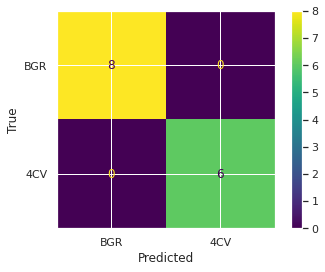

In [14]:
report = classification_report(y_true_list, y_pred_list)
print(report)
# report_support = precision_recall_fscore_support(y_true_list, y_pred_list)
# print(report_support)

def metrics_report_to_df(ytrue, ypred):
    classification_report_df = pd.DataFrame(data=list(precision_recall_fscore_support(y_true_list, y_pred_list)), \
                                         index=['Precision', 'Recall', 'F1-score', 'Support']).T    
    classification_report_df.loc['weighted avg/Total', :] = precision_recall_fscore_support(ytrue, ypred, average='weighted')
    classification_report_df.loc['Avg/Total', 'Support'] = classification_report_df['Support'].sum()
    return(classification_report_df)

classification_report_df = metrics_report_to_df(y_true_list, y_pred_list)
print(classification_report_df)


# print(confusion_matrix(y_true_list, y_pred_list))
#################################
### PLOTTING CONFUSION MATRIX
cm=confusion_matrix(y_true_list, y_pred_list)
print(cm)
#cm=confusion_matrix(y_true_list, y_pred_list, normalize='all')
cmd = ConfusionMatrixDisplay(cm, display_labels=['BGR','4CV'])
cmd.plot()
cmd.ax_.set(xlabel='Predicted', ylabel='True')


#### PREPARING AND SAVING TRAINING PERFORMANCE PARAMETERS
train_values = {} # instantiate an empty train_values dict 
train_values['elapsed_time_in_secs'] = elapsed_time
train_values['MAX_EPOCHS'] = MAX_EPOCHS
train_values['LEARNING_RATE'] = LEARNING_RATE
train_values['BATCH_SIZE_OF_CLIPS'] = BATCH_SIZE_OF_CLIPS
train_values['PRETRANSFORM_IM_SIZE'] = PRETRANSFORM_IM_SIZE
train_values['FRAMES_PER_CLIP'] = NUMBER_OF_FRAMES_PER_SEGMENT_IN_A_CLIP
train_values['Train Dataset Size'] = len(train_set)*NUMBER_OF_FRAMES_PER_SEGMENT_IN_A_CLIP*BATCH_SIZE_OF_CLIPS
train_values['Test Dataset Size'] = len(test_set)*NUMBER_OF_FRAMES_PER_SEGMENT_IN_A_CLIP*BATCH_SIZE_OF_CLIPS
train_values['Validation Dataset Size'] = len(validation_dataset)*NUMBER_OF_FRAMES_PER_SEGMENT_IN_A_CLIP*BATCH_SIZE_OF_CLIPS
train_values['Current date and time'] = datetime.now().strftime('%dD-%mM-%yY_%HH-%MM-%SS')
#team['konqi'] = {'health': 18, 'level': 7}

## Saving training curves at $HOME/repositories/echocardiography/scripts/learning-pipeline/results
os.chdir(TRAINING_CURVES_PATH)
TRAIN_FILE_NAME = TEMP_DICT_TRAINING_CURVES_FOR+"TRAINING_PARAMETERS"+PARAMETERS_FILENAME+".json"


with open(TRAIN_FILE_NAME, 'w') as file:
     file.write(json.dumps(train_values, indent=4))

        


## 12. [**!WARNING!**] Cleanup temporal data directory 
Remove directory if a temporary was used.

```
       Make sure you know which path you will remove as you do not like to remove important files.
       shutil.rmtree
```

In [15]:
temporal_files_path = config['temporal_data_path']

shutil.rmtree(temporal_files_path)
print(f' {temporal_files_path} is empty')

 /home/mx19/datasets/vital-us/echocardiography/temporal-files/ is empty
